# Atividade 7 - Classificador SVM
# Relief - Normalizado
# Algoritmo SVC

SVM:

● Realizar validação cruzada k=10 para testar SVMs utilizando:
    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2 (opcional)

Em cada um, calibrar os parâmetros (kernel, parâmetros do kernel e C) e reportar os valores médios de precisão, revocação e acurácia para o que apresentou melhor acurácia (com os respectivos intervalos de confiança)

## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing


# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.svm import SVC # C-Support Vector Classification
from sklearn.svm import LinearSVC # Linear Support Vector Classification
from sklearn.svm import NuSVC # Nu-Support Vector Classification


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


### Características selecionadas pelo Relief na atividade 4

In [3]:
selecionadas_Relief = ['Age',
                       'Num of pregnancies',
                       'Hormonal Contraceptives (years)',
                       'First sexual intercourse',
                       'STDs (number)',
                       'STDs: Number of diagnosis',
                       'Hinselmann',
                       'Schiller',
                       'Citology', 
                       'STDs']

## Pré-Processamento

In [4]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [5]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:

    Para features categoricas --> preenche com o valor mais frequente

No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)


In [6]:
continuous_feat = [ 'Age',
                    'Num of pregnancies',
                    'Hormonal Contraceptives (years)',
                    'First sexual intercourse',
                    'STDs (number)',
                    'STDs: Number of diagnosis'] 

binary_feat = ['Hinselmann',
               'Schiller',
               'Citology', 
               'STDs']

In [7]:
df_imp = df_processed.copy()

In [8]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()

## Stratified Cross- Validation

### Dataset Desbalanceado

In [9]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
        
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    kernels = grid_params.get('kernels')
    gamma_range = grid_params.get('gamma_range')
    gamma_step = grid_params.get('gamma_step')
    C_range = grid_params.get('C_range')
    
    # Testa varios KERNELS
    for kernel in kernels:
        print("-> Teste Kernel {}".format(kernel))
        
        # Testa varios C
        for c in C_range:
#             print("\t\tTeste Param C {}".format(c))
        
            if kernel in ['rbf', 'poly', 'sigmoid']:
                # Testa varios GAMMA
                for gamma in list(np.arange(gamma_range[0], gamma_range[1], gamma_step))+['scale', 'auto']:
#                     print("\t\t\tTeste Param Gamma {}".format(gamma))
                    
                    print('-> Criando modelo com params c={}, gamma={}'.format(c, gamma))
                    pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()), 
                                           ('clf', algoritmo(kernel=kernel, gamma=gamma, C=c, 
                                                             verbose=1, shrinking=shrinking))])        
                    
                    # Folds
                    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                        fold_number = fold
                        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                        # quantidade de classes dentro da fold
                        count_classes_fold = y.iloc[test_index].value_counts()
                        # proporções
                        prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                        prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                        print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))

                        # aplica o classificador
                        pipe_clf.fit(X_train, y_train)
                        #display(clf)

                        # predict no dataset de treino 
                        y_train_preds = pipe_clf.predict(X_train)
                        # predict no dataset de teste
                        y_pred = pipe_clf.predict(X_test)

                        print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                         % (y_test.shape[0], (y_test != y_pred).sum()))
                       # print("Number of points predicted as Pos: %d"
                       #  % ((y_pred == 1).sum()))

                        # Scores do model (utilizados dados nao-balanceados) - dados de teste
                        recall = recall_score(y_test, y_pred)
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred)
                        scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

            #return np.array(scores)
            else:
                print('-> Criando modelo com params c={}'.format(c))
                pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()), 
                                     ('clf', algoritmo(kernel=kernel, C=c, 
                                                       verbose=1, shrinking=shrinking))])
                
                # utilizando valor default de gamma
                #gamma = clf.gamma # para acompanhamento dos scores
                gamma = pipe_clf.get_params()['clf'].gamma
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # quantidade de classes dentro da fold
                    count_classes_fold = y.iloc[test_index].value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                        count_classes_fold[1],
                                                                                        count_classes_fold[0], 
                                                                                        count_classes_fold.sum(),
                                                                                        prop_pos, prop_neg))
                    
                    # aplica o classificador
                    pipe_clf.fit(X_train, y_train)
                    #display(clf)

                    # predict no dataset de treino 
                    y_train_preds = pipe_clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = pipe_clf.predict(X_test)
                    
                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                     % (y_test.shape[0], (y_test != y_pred).sum()))
                   # print("Number of points predicted as Pos: %d"
                   #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

    return np.array(scores)

### Dataset Balanceado

In [10]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    kernels = grid_params.get('kernels')
    gamma_range = grid_params.get('gamma_range')
    gamma_step = grid_params.get('gamma_step')
    C_range = grid_params.get('C_range')
    
    # Testa varios KERNELS
    for kernel in kernels:
        print("-> Teste Kernel {}".format(kernel))
        
        # Testa varios C
        for c in C_range:
#             print("\t\tTeste Param C {}".format(c))
        
            if kernel in ['rbf', 'poly', 'sigmoid']:
                # Testa varios GAMMA
                for gamma in list(np.arange(gamma_range[0], gamma_range[1], gamma_step))+['scale', 'auto']:
#                     print("\t\t\tTeste Param Gamma {}".format(gamma))
                    
                    print('-> Criando modelo com params c={}, gamma={}'.format(c, gamma))
                    pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()), 
                                         ('clf', algoritmo(kernel=kernel, gamma=gamma, C=c, 
                                                           verbose=1, shrinking=shrinking))])  
                    
                    # Folds
                    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                        fold_number = fold
                        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                        X_test, y_test = X.iloc[test_index], y.iloc[test_index]
                        
                        # Normaliza MinMax para aplicar Smote
                        X_train_normalized = minmax_scale.fit_transform(X_train)
                        X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())
                        
                        # SMOTETomek (apenas os dados de treino)
                        print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                        X_train, y_train = cc.fit_resample(X_train_normalized, y_train)
                        
                        # Retorna para valores não normalizados
                        X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                        print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                                 y_train.value_counts()[0], 
                                                                                                 y_train.value_counts()[1], 
                                                                                                 ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                                 ((y_train.value_counts()[1]/len(y_train))*100)))

                        # quantidade de classes dentro da fold
                        count_classes_fold = y_test.value_counts()
                        # proporções
                        prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                        prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                        print('\t\tDados de teste (desbalanceados)')
                        print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))
                        # aplica o classificador
                        pipe_clf.fit(X_train, y_train)
                        #display(clf)

                        # predict no dataset de treino 
                        y_train_preds = pipe_clf.predict(X_train)
                        # predict no dataset de teste
                        y_pred = pipe_clf.predict(X_test)

                        print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                         % (y_test.shape[0], (y_test != y_pred).sum()))
                       # print("Number of points predicted as Pos: %d"
                       #  % ((y_pred == 1).sum()))

                        # Scores do model (utilizados dados nao-balanceados) - dados de teste
                        recall = recall_score(y_test, y_pred)
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred)
                        scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

            #return np.array(scores)
            else:
                print('-> Criando modelo com params c={}'.format(c))
                pipe_clf = Pipeline([('scaler', preprocessing.StandardScaler()),
                                     ('clf', algoritmo(kernel=kernel, C=c, verbose=1, shrinking=shrinking))])
                
                # utilizando valor default de gamma
                #gamma = clf.gamma # para acompanhamento dos scores
                gamma = pipe_clf.get_params()['clf'].gamma
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # Normaliza MinMax para aplicar Smote
                    X_train_normalized = minmax_scale.fit_transform(X_train)
                    X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

                    # SMOTETomek (apenas os dados de treino)
                    print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                    X_train, y_train = cc.fit_resample(X_train_normalized, y_train)

                    # Retorna para valores não normalizados
                    X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
                    print('\t\tFold = {}, Dataset (balanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(fold_number, 
                                                                                             y_train.value_counts()[0], 
                                                                                             y_train.value_counts()[1], 
                                                                                             ((y_train.value_counts()[0]/len(y_train))*100), 
                                                                                             ((y_train.value_counts()[1]/len(y_train))*100)))

                    # quantidade de classes dentro da fold
                    count_classes_fold = y_test.value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('\t\tDados de teste (desbalanceados)')
                    print('\t\tFold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                        count_classes_fold[1],
                                                                                        count_classes_fold[0], 
                                                                                        count_classes_fold.sum(),
                                                                                        prop_pos, prop_neg))
                    # aplica o classificador
                    pipe_clf.fit(X_train, y_train)
                    #display(clf)

                    # predict no dataset de treino 
                    y_train_preds = pipe_clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = pipe_clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                     % (y_test.shape[0], (y_test != y_pred).sum()))
                   # print("Number of points predicted as Pos: %d"
                   #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([kernel, c, gamma, fold_number, precision, recall, accuracy])

    return np.array(scores)

## Grid de Parametros para teste

In [11]:
grid_params_all = {'gamma_range': [1e-4, 10e-1],
               'gamma_step': 0.01,
               'kernels': ['linear', 'poly', 'rbf', 'sigmoid'],#, 'precomputed'],
               'C_range': [1, 10, 100, 1000]
              }

grid_params_semi = {'gamma_range': [1e-4, 10e-1],
               'gamma_step': 0.01,
               'kernels': ['linear', 'rbf', 'sigmoid'],#, 'precomputed'],
               'C_range': [1, 10, 100, 1000]
              }

grid_params_linear = {'kernels': ['linear'],
                      'C_range': [1, 10, 100, 1000]
                     }


grid_params_sigmoid = {'kernels': ['sigmoid'],
                      'gamma_range': [1e-4, 10e-1],
                       'gamma_step': 0.01,
                        'C_range': [1, 10, 100, 1000]
                       }


grid_params_rbf = {'gamma_range': [1e-4, 10e-1],
                   'gamma_step': 0.01,
                   'kernels': ['rbf'],
                   'C_range': [1, 10, 100, 1000]
                   }

## Calculando Precisão, Revocação e Acurácia

### Algortimo-> SVC

In [12]:
df_selecionado = df_imp[selecionadas_Relief]
df_selecionado = df_selecionado.join(df_imp['Biopsy'])

df_selecionado.head()

Age  Num of pregnancies  Hormonal Contraceptives (years)  First sexual intercourse  STDs (number)  STDs: Number of diagnosis  Hinselmann  Schiller  Citology  STDs  Biopsy
0  18.0                 1.0                              0.0                      15.0            0.0                        0.0         0.0       0.0       0.0   0.0       0
1  15.0                 1.0                              0.0                      14.0            0.0                        0.0         0.0       0.0       0.0   0.0       0
2  34.0                 1.0                              0.0                      17.0            0.0                        0.0         0.0       0.0       0.0   0.0       0
3  52.0                 4.0                              3.0                      16.0            0.0                        0.0         0.0       0.0       0.0   0.0       0
4  46.0                 4.0                             15.0                      21.0            0.0                        0.0         0.0       0.0       0.0   0.0       0

### Dataset Desbalanceado

Atenção:

Durante o treinamento, por conta do Verbose=1, o algoritmo de otimização detectou que, com alta probabilidade seria possivel acelerar o treinamento colocando -h 0 nos parametros. 

Basicamente, -h é a heurística cada vez menor, implementada no pacote libsvm que, para alguns dados, reduz significativamente o número de computações necessárias, enquanto em outras, o torna mais lento

A mensagem que foi exibida foi: "Warning: using -h 0 may be faster"

-h == parametro shrinking do SVC

Por isso esse parametro é passado a função de cross validation como FALSE (default é True)

In [13]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_selecionado, k, SVC, random_state, grid_params_semi, 
                                                   shuffle=False, shrinking=False))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'Kernel', 1: 'c', 2: 'Gamma', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'SVC'
float_cols = ['c', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.svm._classes.SVC'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Kernel linear
-> Criando modelo com params c=1
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Num

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 1
-> Criando modelo com params c=1, gamma=0.0201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 2
-> Criando modelo com params c=1, gamma=0.0801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.21009999999999998
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Nume

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.3301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.4401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.5001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.6201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.7501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.8101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.8701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.9301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.9901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 2
-> Criando modelo com params c=10, gamma=0.10010000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Num

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 2
-> Criando modelo com params c=10, gamma=0.1601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x

-> Criando modelo com params c=10, gamma=0.3901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.4501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.5101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=10, gamma=0.6201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=10, gamma=0.6901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

-> Criando modelo com params c=10, gamma=0.7501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=10, gamma=0.8201
Fold 

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.8801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=10, gamma=0.9401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

-> Criando modelo com params c=10, gamma=scale
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanci

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 2
-> Criando modelo com params c=100, gamma=0.040100000000000004
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	N

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=100, gamma=0.10010000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	

Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=100, gamma=0.2201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.3401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=100, gamma=0.4001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.4601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.5201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.5801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.7501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de insta

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.8101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.8601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.9201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=100, gamma=0.9801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 2
-> Criando modelo com params c=1000, gamma=0.0201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=1000, gamma=0.1401
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.1901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.2501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.3101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.3701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.4301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.4901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.6101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fol

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.7401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.8001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.9801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 2
-> Criando modelo com params c=1, gamma=0.0201
Fold 1

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.1401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.2001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.3301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

-> Criando modelo com params c=1, gamma=0.4501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanci

-> Criando modelo com params c=1, gamma=0.5101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanci

Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.6301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.6901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.7501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.8101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.9301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.9901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instanc

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=10, gamma=0.0901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.1601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.29009999999999997
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Num

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=10, gamma=0.3501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=10, gamma=0.4101
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

-> Criando modelo com params c=10, gamma=0.4701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanc

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=10, gamma=0.5901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.6501
Fold

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.8301000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Nume

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.8901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.9501000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanci

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=10, gamma=auto
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instanci

Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instanc

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.1201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de insta

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=100, gamma=0.2501
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de insta

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=100, gamma=0.3801
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=100, gamma=0.4401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de insta

-> Criando modelo com params c=100, gamma=0.5001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instan

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% 

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instanc

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1000, gamma=0.0301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.1601
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.2301
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fol

-> Criando modelo com params c=1000, gamma=0.29009999999999997
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Nu

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.3601
Fo

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.4201
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de inst

Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.48009999999999997
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	N

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.5401
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.6001
Fol

Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instan

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% 

Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.7701
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de ins

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.8301000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Nu

Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.8901
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de inst

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1000, gamma=0.9501000000000001
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instan

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=auto
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instan

In [14]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Relief-Normalizacao_SVC.xlsx', 
                           encoding='utf-8-sig')

Kernel  c  Gamma  Fold  Precision    Recall  Accuracy Algorimto
0  linear  1  scale     1   0.555556  1.000000  0.953488       SVC
1  linear  1  scale     2   0.833333  1.000000  0.988372       SVC
2  linear  1  scale     3   0.571429  0.800000  0.953488       SVC
3  linear  1  scale     4   0.857143  1.000000  0.988372       SVC
4  linear  1  scale     5   0.500000  0.666667  0.930233       SVC

### Dataset Balanceado

In [15]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_selecionado, k, SVC, random_state, grid_params_semi, 
                                                   shuffle=False, shrinking=False))
scores_balanced = scores_balanced.rename(columns = {0: 'Kernel', 1: 'c', 2: 'Gamma', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_balanced['Algorimto'] = 'SVC'
float_cols = ['c', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.svm._classes.SVC'>
------
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Kernel linear
-> Criando modelo com params c=1
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 8

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 1
-> Criando mode

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados

		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[L

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativa

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativa

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 2
-> Criando modelo com params c=1, gamma=0.1901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 2
-> Criando mode

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativa

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativa

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=1, gamma=0.3301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 3...
		Fold = 3,

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando mode

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativa

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1, gamma=0.4701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas d

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.5001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 3...
		Fold = 3,

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1, gamma=0.5301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2,

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando mode

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativa

-> Criando modelo com params c=1, gamma=0.6401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Da

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1, gamma=0.6701
	Balanceando dados de treino fold 1...
		Fold = 1,

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativa

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativa

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.7501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2,

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativa

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativa

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1, gamma=0.8301000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 3...

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negati

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativa

-> Criando modelo com params c=1, gamma=0.9101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Da

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.9401
	Balanceando dados de treino fold 1...
		Fold = 1,

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=0.9701
	Balanceando dados de treino fold 1...
		Fold = 1,

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1, gamma=scale
	Balanceando dados de treino fold 1...
		Fold = 1, 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados

-> Criando modelo com params c=10, gamma=0.0901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, D

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 3
-> Criando modelo com params c=10, gamma=0.1201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 3...
		Fold = 3

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negati

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negati

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativa

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=10, gamma=0.3201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 3...
		Fold = 3

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=10, gamma=0.3501
	Balanceando dados de treino fold 1...
		Fold = 1

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativa

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=10, gamma=0.4301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando mode

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando mode

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativa

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativ

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.6001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando mode

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativa

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dado

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativ

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.7401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativa

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativ

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.8201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negati

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativa

-> Criando modelo com params c=10, gamma=0.9001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, D

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.9301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas 

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=10, gamma=0.9601
	Balanceando dados de treino fold 1...
		Fold = 1

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=10, gamma=0.9901
	Balanceando dados de treino fold 1...
		Fold = 1

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 2
-> Criando modelo com params c=100, gamma=0.0001
	Balanceando dados de treino fold 1...
		Fold = 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
-> Criando modelo com params c=100, gamma=0.1101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=100, gamma=0.1401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold =

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando mode

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dado

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.3101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.3401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.3701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados

-> Criando modelo com params c=100, gamma=0.48009999999999997
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.5101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando mode

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados

		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=100, gamma=0.6801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando mod

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativ

		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[L

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=100, gamma=0.8501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando mod

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=100, gamma=0.9601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando mod

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1000, gamma=0.0801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.1601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.1901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Criando modelo com params c=1000, gamma=0.3001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.3301
	Balanceando dados de treino fold 1...
		Fold 

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativ

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativ

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 4
-> Criando modelo com params c=1000, gamma=0.4401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dado

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativa

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.5501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.6601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.6901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
	Balanceando dado

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativ

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.8001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 6
-> Criando modelo com params c=1000, gamma=0.8301000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dado

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.9401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 7
-> Criando modelo com params c=1000, gamma=0.9701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 8
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 1
	Balanceando dados

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dad

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negati

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negati

		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%


[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando da

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=1, gamma=0.18009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando da

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negati

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=1, gamma=0.3201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 2...
		Fold =

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negat

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negati

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=1, gamma=0.4001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 3...
		Fold =

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando d

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negati

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negati

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
-> Criando modelo com params c=1, gamma=0.5401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
-> Criando modelo com params c=1, gamma=0.6501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=1, gamma=0.7601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=1, gamma=0.7901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas err

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 21
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
-> Criando modelo com params c=1, gamma=0.9001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errada

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 21
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
-> Criando modelo com params c=1, gamma=0.9301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold =

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando d

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negati

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativa

-> Criando modelo com params c=10, gamma=0.050100000000000006
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 4

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=10, gamma=0.0801
	Balanceando dados de treino fold 1...
		Fold =

	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negati

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=10, gamma=0.1901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando da

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=10, gamma=0.3001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 2...
		Fold 

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negat

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negati

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=10, gamma=0.3801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 3...
		Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando da

-> Criando modelo com params c=10, gamma=0.4601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 4...
		Fold = 4

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=10, gamma=0.4901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=10, gamma=0.5701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 30
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=10, gamma=0.6001
	Balanceando dados de treino fold 1...
		Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=10, gamma=0.7401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=10, gamma=0.7701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas er

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
-> Criando modelo com params c=10, gamma=0.9101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas errad

	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 21
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
-> Criando modelo com params c=10, gamma=0.9401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 2...
		Fold 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 21
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 4
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 2
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negati

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negati

-> Criando modelo com params c=100, gamma=0.0901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 4...
		Fold = 

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 10
-> Criando modelo com params c=100, gamma=0.1201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=100, gamma=0.15009999999999998
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias cl

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando da

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando modelo com params c=100, gamma=0.29009999999999997
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fol

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 19
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 neg

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negati

-> Criando modelo com params c=100, gamma=0.3701
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold = 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=100, gamma=0.48009999999999997
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias class

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
-> Criando modelo com params c=100, gamma=0.5901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=100, gamma=0.6201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
-> Criando modelo com params c=100, gamma=0.6501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 11
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=100, gamma=0.7601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negat

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negat

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=100, gamma=0.9601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 21
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=100, gamma=0.9901
	Balanceando dados de treino fold 1...
		Fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 5
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dad

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 8
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 3
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dad

-> Criando modelo com params c=1000, gamma=0.050100000000000006
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 9
-> Criando modelo com params c=1000, gamma=0.0801
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas e

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=1000, gamma=0.1101
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 neg

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando da

		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 6
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%


[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=1000, gamma=0.2201
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 25
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 16
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=1000, gamma=0.2501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negat

	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negati

	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=1000, gamma=0.3301
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 26
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 3...
		Fol

	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 neg

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 7
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negati

	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negat

-> Criando modelo com params c=1000, gamma=0.4401
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold =

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 18
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 11
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 9
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando da

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 32
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 20
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 17
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
-> Criando modelo com params c=1000, gamma=0.5501
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 15
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 19
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 24
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 10
	Balanceando d

-> Criando modelo com params c=1000, gamma=0.6601
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 27
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 35
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 4...
		Fold =

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 31
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 21
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 12
-> Criando modelo com params c=1000, gamma=0.6901
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 21
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 29
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 17
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 14
-> Criando modelo com params c=1000, gamma=0.8301000000000001
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 21
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 33
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias class

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 20
	Balanceando dados de treino fold 10...
		Fold = 10, Dataset (balanceado) 720 positivas e 720 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 15
-> Criando 

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando dados de treino fold 8...
		Fold = 8, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 28
	Balanceando dados de treino fold 9...
		Fold = 9, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 20
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 7...
		Fold = 7, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 16
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando dados de treino fold 6...
		Fold = 6, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 18
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 34
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 22
	Balanceando dados de treino fold 4...
		Fold = 4, Dataset (balanceado) 721 positivas e 721 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 12
	Balanceando dados de treino fold 5...
		Fold = 5, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 14
	Balanceando d

[LibSVM]	Numero de instancias classificadas erradas do total de 85 instancias : 13
-> Criando modelo com params c=1000, gamma=scale
	Balanceando dados de treino fold 1...
		Fold = 1, Dataset (balanceado) 718 positivas e 718 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 23
	Balanceando dados de treino fold 2...
		Fold = 2, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erradas do total de 86 instancias : 13
	Balanceando dados de treino fold 3...
		Fold = 3, Dataset (balanceado) 719 positivas e 719 negativas (50.00% x 50.00%)
		Dados de teste (desbalanceados)
		Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
[LibSVM]	Numero de instancias classificadas erra

In [16]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Relief-Normalizado_SVC.xlsx', 
                           encoding='utf-8-sig')

Kernel  c  Gamma  Fold  Precision    Recall  Accuracy Algorimto
0  linear  1  scale     1   0.555556  1.000000  0.953488       SVC
1  linear  1  scale     2   0.833333  1.000000  0.988372       SVC
2  linear  1  scale     3   0.571429  0.800000  0.953488       SVC
3  linear  1  scale     4   0.857143  1.000000  0.988372       SVC
4  linear  1  scale     5   0.500000  0.666667  0.930233       SVC

## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [17]:
mean_unbalanced = scores_unbalanced.groupby(['Kernel','c','Gamma']).mean().drop('Fold', axis = 1)
mean_unbalanced

Precision    Recall  Accuracy
Kernel  c    Gamma                                              
linear  1    scale                  0.683135  0.876667  0.961546
        10   scale                  0.683135  0.876667  0.961546
        100  scale                  0.683135  0.876667  0.961546
        1000 scale                  0.683135  0.876667  0.961546
rbf     1    0.0001                 0.000000  0.000000  0.935910
             0.0101                 0.679603  0.840000  0.960383
             0.0201                 0.674246  0.823333  0.959220
             0.0301                 0.688532  0.753333  0.958044
             0.040100000000000004   0.687500  0.656667  0.955705
             0.050100000000000006   0.699643  0.676667  0.958044
             0.0601                 0.717143  0.660000  0.959207
             0.07010000000000001    0.726667  0.660000  0.960369
             0.0801                 0.736667  0.676667  0.961532
             0.0901                 0.726667  0.660000  0.960369
             0.10010000000000001    0.736667  0.660000  0.961546
             0.1101                 0.726667  0.643333  0.961546
             0.1201                 0.726667  0.643333  0.961546
             0.1301                 0.705000  0.583333  0.958044
             0.1401                 0.711667  0.546667  0.956881
             0.15009999999999998    0.711667  0.546667  0.956881
             0.1601                 0.661667  0.510000  0.954555
             0.1701                 0.661667  0.510000  0.954555
             0.18009999999999998    0.661667  0.510000  0.954555
             0.1901                 0.661667  0.510000  0.954555
             0.2001                 0.676667  0.456667  0.951040
             0.21009999999999998    0.676667  0.436667  0.949877
             0.2201                 0.676667  0.416667  0.948714
             0.2301                 0.676667  0.400000  0.947551
             0.24009999999999998    0.676667  0.400000  0.947551
             0.2501                 0.576667  0.380000  0.946389
             0.2601                 0.536667  0.360000  0.946389
             0.2701                 0.521667  0.340000  0.945212
             0.2801                 0.521667  0.340000  0.945212
             0.29009999999999997    0.521667  0.340000  0.945212
             0.3001                 0.521667  0.340000  0.945212
             0.3101                 0.521667  0.306667  0.942886
             0.3201                 0.521667  0.306667  0.942886
             0.3301                 0.508333  0.273333  0.940561
             0.3401                 0.508333  0.273333  0.940561
             0.3501                 0.508333  0.273333  0.940561
             0.3601                 0.501667  0.253333  0.939398
             0.3701                 0.501667  0.253333  0.939398
             0.3801                 0.501667  0.253333  0.939398
             0.3901                 0.501667  0.253333  0.939398
             0.4001                 0.501667  0.253333  0.939398
             0.4101                 0.501667  0.236667  0.938235
             0.4201                 0.501667  0.236667  0.938235
             0.4301                 0.501667  0.236667  0.938235
             0.4401                 0.491667  0.216667  0.937073
             0.4501                 0.491667  0.216667  0.937073
             0.4601                 0.491667  0.216667  0.937073
             0.4701                 0.491667  0.216667  0.937073
             0.48009999999999997    0.491667  0.200000  0.935910
             0.4901                 0.491667  0.200000  0.935910
             0.5001                 0.491667  0.200000  0.935910
             0.5101                 0.491667  0.200000  0.937073
             0.5201                 0.500000  0.200000  0.938249
             0.5301                 0.500000  0.200000  0.938249
             0.5401                 0.483333  0.183333  0.937086
             0.5501                 0.450000  0.143333  0.934733
     

In [18]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

Precision    Recall  Accuracy
Kernel c Gamma                                             
rbf    1 scale                 0.736667  0.660000  0.961546
         0.10010000000000001   0.736667  0.660000  0.961546
         auto                  0.736667  0.660000  0.961546
         0.1201                0.726667  0.643333  0.961546
         0.1101                0.726667  0.643333  0.961546

('rbf', 1, '0.10010000000000001')

### Dataset Balanceado

In [19]:
mean_balanced = scores_balanced.groupby(['Kernel','c','Gamma']).mean().drop('Fold', axis = 1)
mean_balanced

Precision    Recall  Accuracy
Kernel  c    Gamma                                              
linear  1    scale                  0.683135  0.876667  0.961546
        10   scale                  0.683135  0.876667  0.961546
        100  scale                  0.683135  0.876667  0.961546
        1000 scale                  0.683135  0.876667  0.961546
rbf     1    0.0001                 0.677976  0.770000  0.958044
             0.0101                 0.697222  0.876667  0.963871
             0.0201                 0.690278  0.876667  0.962709
             0.0301                 0.681389  0.856667  0.960383
             0.040100000000000004   0.681389  0.856667  0.960383
             0.050100000000000006   0.681190  0.856667  0.960383
             0.0601                 0.667698  0.856667  0.959220
             0.07010000000000001    0.667698  0.856667  0.959220
             0.0801                 0.662143  0.840000  0.958057
             0.0901                 0.662143  0.840000  0.958057
             0.10010000000000001    0.662143  0.820000  0.956881
             0.1101                 0.650000  0.783333  0.954555
             0.1201                 0.644444  0.763333  0.953379
             0.1301                 0.644444  0.763333  0.953379
             0.1401                 0.648929  0.763333  0.953365
             0.15009999999999998    0.653690  0.746667  0.953365
             0.1601                 0.648929  0.746667  0.953365
             0.1701                 0.665278  0.746667  0.955705
             0.18009999999999998    0.675278  0.746667  0.956867
             0.1901                 0.666944  0.726667  0.955705
             0.2001                 0.631944  0.650000  0.951053
             0.21009999999999998    0.631944  0.650000  0.951053
             0.2201                 0.624802  0.633333  0.951053
             0.2301                 0.586706  0.600000  0.948728
             0.24009999999999998    0.611706  0.600000  0.949891
             0.2501                 0.611706  0.600000  0.949891
             0.2601                 0.611706  0.600000  0.949891
             0.2701                 0.611706  0.600000  0.949891
             0.2801                 0.602183  0.600000  0.948728
             0.29009999999999997    0.595040  0.563333  0.946402
             0.3001                 0.589484  0.563333  0.945239
             0.3101                 0.589484  0.563333  0.945239
             0.3201                 0.574484  0.563333  0.945226
             0.3301                 0.580040  0.563333  0.946402
             0.3401                 0.563373  0.563333  0.945239
             0.3501                 0.563373  0.543333  0.944077
             0.3601                 0.556230  0.523333  0.942900
             0.3701                 0.556230  0.523333  0.942900
             0.3801                 0.549286  0.523333  0.941737
             0.3901                 0.543929  0.523333  0.940561
             0.4001                 0.543929  0.523333  0.940561
             0.4101                 0.443929  0.503333  0.939398
             0.4201                 0.421984  0.486667  0.937059
             0.4301                 0.410198  0.486667  0.935869
             0.4401                 0.405437  0.470000  0.934706
             0.4501                 0.398770  0.453333  0.933543
             0.4601                 0.398770  0.453333  0.933543
             0.4701                 0.393413  0.453333  0.932380
             0.48009999999999997    0.393413  0.453333  0.932380
             0.4901                 0.400556  0.453333  0.933557
             0.5001                 0.400556  0.453333  0.933557
             0.5101                 0.390556  0.433333  0.932380
             0.5201                 0.383889  0.433333  0.931204
             0.5301                 0.383889  0.433333  0.931204
             0.5401                 0.374960  0.413333  0.930027
             0.5501                 0.369405  0.396667  0.928865
     

In [20]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

Precision    Recall  Accuracy
Kernel c    Gamma                                
rbf    1    0.0101   0.697222  0.876667  0.963871
            0.0201   0.690278  0.876667  0.962709
linear 1    scale    0.683135  0.876667  0.961546
rbf    1000 0.0001   0.683135  0.876667  0.961546
linear 10   scale    0.683135  0.876667  0.961546

('rbf', 1, '0.0101')

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [21]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['Kernel'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['c'] == max_alpha_unbalanced[1]) &
                                                             (scores_unbalanced['Gamma'] == max_alpha_unbalanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.962, IC = [0.943, 0.980]
Recall: Média = 0.660, IC = [0.521, 0.799]
Precisão: Média = 0.737, IC = [0.574, 0.899]


### Dataset Balanceado

In [22]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['Kernel'] == max_alpha_balanced[0]) &
                                                       (scores_balanced['c'] == max_alpha_balanced[1]) &
                                                       (scores_balanced['Gamma'] == max_alpha_balanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.964, IC = [0.950, 0.978]
Recall: Média = 0.877, IC = [0.793, 0.960]
Precisão: Média = 0.697, IC = [0.577, 0.818]


## Gráfico

In [23]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

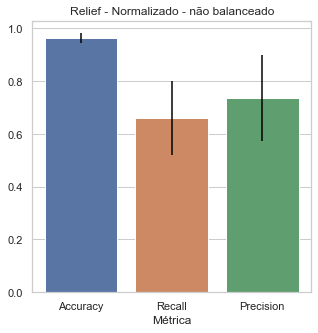

In [24]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('Relief - Normalizado - não balanceado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('Relief-Normalizado-nao_balanceado-SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(152.00000000000003, 0.5, '')]

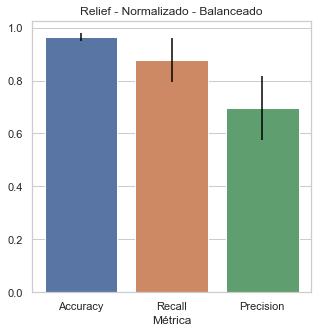

In [25]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('Relief - Normalizado - Balanceado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('Relief-Normalizado-balanceado-SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [42]:
path_to_save = '../../model_results/'

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

intervalo_confianca = []

for metrica in df_mean_unbalanced.index:
    # Coleta os Indices de Confianca
    if df_mean_unbalanced.loc[metrica]['Métrica'] == 'Accuracy':
        intervalo_confianca = [mean_unbalanced[0], acc_min_unbalanced, acc_max_unbalanced]
    if df_mean_unbalanced.loc[metrica]['Métrica'] == 'Recall':
        intervalo_confianca = [mean_unbalanced[1], rec_min_unbalanced, rec_max_unbalanced]
    if df_mean_unbalanced.loc[metrica]['Métrica'] == 'Precision':
        intervalo_confianca = [mean_unbalanced[2], pre_min_unbalanced, pre_max_unbalanced]
    result = [
    '7',
    'SVC',
    'ReliefF Desbalanceado - Normalizado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    intervalo_confianca
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    # Coleta os Indices de Confianca
    if df_mean_balanced.loc[metrica]['Métrica'] == 'Accuracy':
        intervalo_confianca = [mean_balanced[0], acc_min_balanced, acc_max_balanced]
    if df_mean_balanced.loc[metrica]['Métrica'] == 'Recall':
        intervalo_confianca = [mean_balanced[1], rec_min_balanced, rec_max_balanced]
    if df_mean_balanced.loc[metrica]['Métrica'] == 'Precision':
        intervalo_confianca = [mean_balanced[2], pre_min_balanced, pre_max_balanced]
    result = [
    '7',
    'SVC',
    'ReliefF Balanceado - Normalizado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value'],
    intervalo_confianca    
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao', 
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

Algoritmo Atividade                                          Condicao  Intervalo_Confianca                Melhores_Params    Metrica       Valor                                                  6
0           SVC         7  Dataset Completo Desbalanceado - Nao Normalizado                  NaN         ('linear', 1, 'scale')   Accuracy    0.960383                                                NaN
1           SVC         7  Dataset Completo Desbalanceado - Nao Normalizado                  NaN         ('linear', 1, 'scale')     Recall        0.86                                                NaN
2           SVC         7  Dataset Completo Desbalanceado - Nao Normalizado                  NaN         ('linear', 1, 'scale')  Precision    0.677579                                                NaN
3           SVC         7     Dataset Completo Balanceado - Nao Normalizado                  NaN         ('rbf', 100, '0.0001')   Accuracy    0.962709                                                NaN
4           SVC         7     Dataset Completo Balanceado - Nao Normalizado                  NaN         ('rbf', 100, '0.0001')     Recall    0.876667                                                NaN
5           SVC         7     Dataset Completo Balanceado - Nao Normalizado                  NaN         ('rbf', 100, '0.0001')  Precision    0.690079                                                NaN
6           SVC         7      Dataset Completo Desbalanceado - Normalizado                  NaN         ('rbf', 100, '0.0001')   Accuracy    0.962709                                                NaN
7           SVC         7      Dataset Completo Desbalanceado - Normalizado                  NaN         ('rbf', 100, '0.0001')     Recall    0.876667                                                NaN
8           SVC         7      Dataset Completo Desbalanceado - Normalizado                  NaN         ('rbf', 100, '0.0001')  Precision    0.690079                                                NaN
9           SVC         7         Dataset Completo Balanceado - Normalizado                  NaN         ('rbf', 100, '0.0001')   Accuracy    0.959193                                                NaN
10          SVC         7         Dataset Completo Balanceado - Normalizado                  NaN         ('rbf', 100, '0.0001')     Recall        0.91                                                NaN
11          SVC         7         Dataset Completo Balanceado - Normalizado                  NaN         ('rbf', 100, '0.0001')  Precision    0.673016                                                NaN
12          SVC         7                                 PCA Desbalanceado                  NaN         ('rbf', 100, '0.0001')   Accuracy    0.963899                                                NaN
13          SVC         7                                 PCA Desbalanceado                  NaN         ('rbf', 100, '0.0001')     Recall        0.64                                                NaN
14          SVC         7                                 PCA Desbalanceado                  NaN         ('rbf', 100, '0.0001')  Precision    0.799524                                                NaN
15          SVC         7                                    PCA Balanceado                  NaN       ('sigmoid', 1, '0.0001')   Accuracy    0.958057                                                NaN
16          SVC         7                                    PCA Balanceado                  NaN       ('sigmoid', 1, '0.0001')     Recall    0.716667                                                NaN
17          SVC         7                                    PCA Balanceado                  NaN       ('sigmoid', 1, '0.0001')  Precision     0.71381                                                NaN
18          SVC         7  Branch and Bound Desbalanceado - Nao Normalizado                  NaN          ('rbf', 10, '0.9201')   Accuracy    0.938235                  

Resultados salvos com sucesso
